<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [45]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content1.webp to content1 (4).webp

Upload Style Image


Saving style1.webp to style1 (5).webp
Content Path: <_io.BytesIO object at 0x7f29e06b03b0>
Style Path: <_io.BytesIO object at 0x7f29e06b00b0>


In [46]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


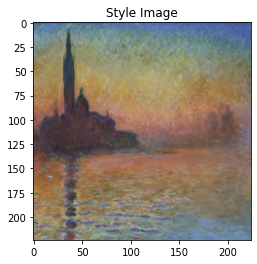

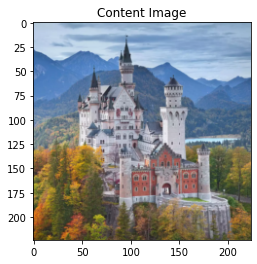

In [47]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [48]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module): # returns dict {layer : feature map}
  def __init__(self, requested=[]):
    #print("requested: ", requested)
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [49]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
contentLayers = [19]
styleLayers = [0,5,10,17,24]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
contentModel = VGGIntermediate(requested=contentLayers).cuda().eval()
styleModel = VGGIntermediate(requested=styleLayers).cuda().eval()

#contentModel.cuda()
#styleModel.cuda()

# Cache the outputs of the content and style layers for their respective images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [50]:
content = contentModel(content_image)
style = styleModel(style_image)

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [51]:
def gram_matrix(input): # literally just a matrix multiply. nice.
   return torch.mm(input,input.t()) 
  
class ContentLoss(nn.Module): #call .detach() on the feature map tensors
  def __init__(self, target,):
    super(ContentLoss, self).__init__()

    self.target = target.detach()  

  def forward(self, pred): #refactor to accept the raw layer
    _, c, w, h = pred.size()
    pred = pred.reshape(c,w*h)

    _, c, w, h = self.target.size()
    temp = self.target.reshape(c,w*h)



  
    self.loss = nn.functional.mse_loss(temp,pred,reduction='sum')
    return pred
    
class StyleLoss(nn.Module):

  def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach()

  def forward(self, pred): #refactor to accept the raw layer

    _, c, w, h = pred.size()
    pred = pred.reshape(c,w*h)

    _, c, w, h = self.target.size()
    temp = self.target.reshape(c,w*h)




    A = gram_matrix(temp)
    G = gram_matrix(pred)
    N, M = temp.size()

    const = 1/(4*(M**2)*(N**2))
    self.loss = const * nn.functional.mse_loss(A,G, reduction = 'sum')
    return pred



    

  

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
contentLoss = ContentLoss(content[19])

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
styleLoss1 = StyleLoss(style[styleLayers[0]]).eval() # I think these are the E's... and we need to sum them...
styleLoss2 = StyleLoss(style[styleLayers[1]]).eval()
styleLoss3 = StyleLoss(style[styleLayers[2]]).eval()
styleLoss4 = StyleLoss(style[styleLayers[3]]).eval()
styleLoss5 = StyleLoss(style[styleLayers[4]]).eval()


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



In [55]:
image = content_image.clone().requires_grad_(True)

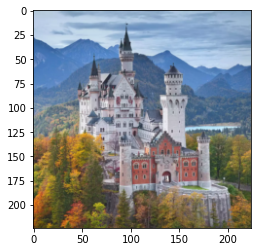

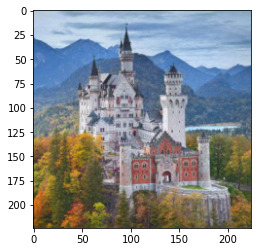

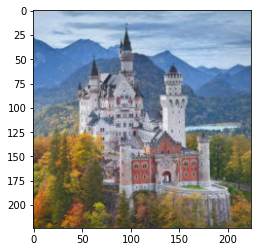

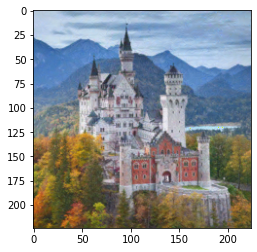

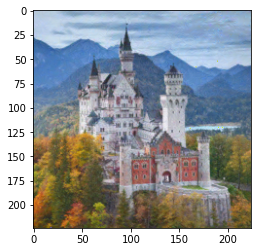

In [56]:
# similar to previous training loops. Optimize on input image. 
# make sure your input image tensor requires the gradient. .requires_grad_(), or wrap as nn.Parameter() --> pass it to the optimizer
#call .backward() on totalLoss

# Start with a copy of the content image
def scope():
  #image = content_image.clone().requires_grad_(True)
  # image = nn.Parameter(image)
  # image = image.cuda()
  cLosses = []
  sLosses = []
  losses = []
  optimizer = optim.Adam([image], lr=5e-4)

  w = 1/5
  alpha = .00001
  beta = 1-alpha
  EPOCHS = 500

  # contentTarget = contentModel(content_image)
  # styleTarget = styleModel(style_image)

  loop = tqdm(total=EPOCHS, position=0, leave=False)

  for epoch in range(EPOCHS):

    #with torch.no_grad():
        #image.clamp_(0, 1)

    optimizer.zero_grad()


    contentPred = contentModel(image).copy()
    stylePred = styleModel(image).copy()

    contentLoss(contentPred[19])
    cLoss = contentLoss.loss

    styleLoss1(stylePred[styleLayers[0]])
    styleLoss2(stylePred[styleLayers[1]])
    styleLoss3(stylePred[styleLayers[2]])
    styleLoss4(stylePred[styleLayers[3]])
    styleLoss5(stylePred[styleLayers[4]])
    sLoss = w*styleLoss1.loss + w*styleLoss2.loss + w*styleLoss3.loss + w*styleLoss4.loss + w*styleLoss5.loss
    totalLoss = alpha*(cLoss) + beta*(sLoss)

    totalLoss.backward()

    losses.append(totalLoss.item()) 
    cLosses.append(cLoss.item())
    sLosses.append(sLoss.item())
    mem = torch.cuda.memory_allocated() / 1e9
    loop.set_description('epoch:{}, loss:{:.4f}, mem:{:.2f}'.format(epoch, totalLoss, mem))
    loop.update(1)

    if epoch%100 == 0:
      plt.figure()
      display(image)

    optimizer.step()
    gc.collect()



  loop.close()
  #with torch.no_grad():
        #image.clamp_(0, 1)

  return image, cLosses, sLosses, losses

image, cLosses, sLosses, losses = scope()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
# Show the image

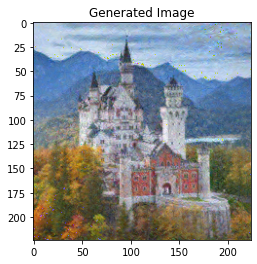

In [58]:
display(image + (image.clamp(0,1) - content_image),title="Generated Image")

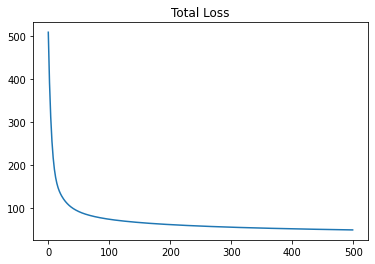

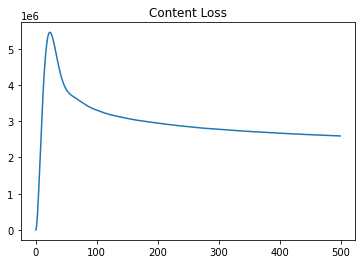

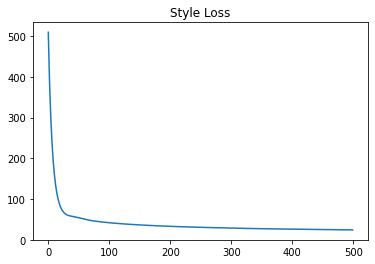

In [59]:
plt.figure()
plt.plot(losses)
plt.title("Total Loss")
plt.show()
plt.figure()
plt.plot(cLosses)
plt.title("Content Loss")
plt.show()
plt.figure()
plt.plot(sLosses)
plt.title("Style Loss")
plt.show()

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Equation 1: $\mathcal{L}_{content} (\vec{p},\vec{x},l) = \frac{1}{2} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$. 

Equation 3: $G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l$. 

Equation 4: $E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2$. 

Equation 5: $\mathcal{L}_{style} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l$ 

Equation 1 is the Loss Function for the "content" of our generated image. Meaning, the global structure.  
$\vec{p}$ is the original image, $\vec{x}$ is the image that is generated and $l$ is the ouput layer. $F_{ij}^l$ is the $M^l * N^l$ matrix ($M = w * h$ for a given layer $l$, $N = c$ for a given layer $l$) that contains the output from our content Model for the input $\vec{x}$, for a given layer $l$. $P$ is the same but for the input $\vec{p}$.

Equation 3 is used to calculate the gram matrix for an output layer. Is is simply the inner product between each of the rows of the matrix, or equivalently the matrix product of $F^l$ and $transpose(F^l)$. 

Equation 4: This is the style loss for a given layer $l$, where $G^l$ and $A^l$ are the gram matrices for $F^l$ and $P^l$ and we calculate their Sum Squared Error, that is weighted by $4N^2M^2$. 

Equation 5: is the total style loss which is simply the weighted sum of the style losses for each layer. The weight $w$ is a hyperparameter.

SyntaxError: ignored